In [1]:
#importation des packages
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Ajouter le chemin vers src au PYTHONPATH
project_root = Path().resolve().parent
#src_path = project_root / "src"
sys.path.insert(0, str(project_root))

# Import depuis src comme un package
from src.data_loader import *
from src.preprocessing import *

### **INTERACTIONS**

**Importation des données pour la table interactions**

In [2]:
data_interactions = load_interactions_data()

In [3]:

## 1er aperçus des données
data_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [4]:
# avoir les informations sur les données types, valeurs manquantes, etc.
data_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [5]:
#conversion des données de la colonne date en type datetime
data_interactions['date'] = pd.to_datetime(data_interactions['date'], format='%Y-%m-%d')

**Valeurs manquantes et doublons**

In [6]:
# vérifier les valeurs manquantes dans la table interactions
missing_values_interactions = detect_missing_values(data_interactions)
print(missing_values_interactions)


review    169
dtype: int64


In [7]:
#essayons d'imputer les valeurs manquantes dans la colonne 'review' en se basant sur 'rating'
def imputer_review(row):
    if pd.isnull(row['review']):
        if row['rating'] == 5:
            return "Excellent recipe! Loved it!"
        elif row['rating'] == 4:
            return "Great recipe, will make again."
        elif row['rating'] == 3:
            return "Good recipe, but could be improved."
        elif row['rating'] == 2:
            return "Not my favorite."
        elif row['rating'] == 1:
            return "Did not like this recipe at all."
    else:
        return row['review']
    
data_interactions['review'] = data_interactions.apply(imputer_review, axis=1)

# Vérifions les valeurs manquantes après l'imputation
print("Valeurs manquantes après imputation :")
print(data_interactions['review'].isnull().sum())

Valeurs manquantes après imputation :
0


In [8]:
#detection des doublons dans recipes meme recipes_id, meme date, meme note, meme review
duplicates_interactions = detect_duplicates(data_interactions)
print("Nombre de doublons dans les interactions :", duplicates_interactions)


if duplicates_interactions > 0:
    # supprimer les doublons
    print("Suppression des doublons...")
    data_interactions = data_interactions.drop_duplicates()
    duplicates_interactions_sub = detect_duplicates(data_interactions)
    print("Nombre de doublons restants dans les interactions :", duplicates_interactions_sub)
    


Nombre de doublons dans les interactions : 0


In [9]:
###Verification si les données sont cohérentes et valides,affichons les lignes dont la note est inferieur a 3
data_interactions[data_interactions['rating'] <= 3].sample(5)

,user_id,recipe_id,date,rating,review
1093119,827032,322948,2009-01-19,2,"This recipe is easy, nutritious, and makes a l..."
675586,2000498330,264808,2016-12-20,0,"Super smooth, super yummy. Perfect cold weathe..."
793834,14410,354710,2009-02-27,3,"This worked as directed, but we didn't like th..."
150114,250449,442985,2012-12-20,3,Really not sure about the ingredients on this ...
740070,1017242,135403,2010-05-21,3,I was a little disappointed that the marinade ...


nous observons que plusieurs lignes du jeu de données présentent une note égale à 0 (rating = 0), tout en contenant un commentaire textuel (review) souvent positif ou négatif.
Cette situation est incohérente : une note de 0 ne correspond pas à une appréciation valide sur une échelle de 1 à 5, et le contenu des commentaires indique que les utilisateurs ont bien exprimé une opinion sur la recette.

Nous en déduisons que la valeur 0 ne traduit pas une mauvaise note, mais plutôt l’absence de note — autrement dit, une valeur manquante codée par 0.

En conséquence, nous considérons toutes les notes égales à 0 comme valeurs manquantes et nous les remplaçons par NaN afin de ne pas biaiser les statistiques descriptives ni les calculs de moyennes.
Cela revient à interpréter ces cas comme des utilisateurs ayant laissé un commentaire sans attribuer de note chiffrée.

In [10]:
##remplacons les notes invalides par NaN
data_interactions.loc[data_interactions['rating'] == 0, 'rating'] = np.nan

**Evaluation de la proportion d'avis négatifs**

Notre étude portant sur les caractéristiques des recettes générant des avis négatifs, nous cherchons dans un premier temps à identifier les avis négatis.

** PROCEDURE **
Au vue de la proportion très importante d'avis positif dans le dataset, nous admettrons qu'une recette est moins appréciée au moins 1 avis sur cette recette présente des suggestions ou des axes d'améliorations. En se basant sur ce constat, 2 features pourraient nous des informations. Dans un premier temps, nous allons considérer les recettes qui ont des avis notés à 3 ou moins et dans un second temps nous allons nous concentrer sur commentaires portant au moins un aspect négatif pour les avis ayant une note de 0 (absencce de note) et 4. Nous nous interesserons pas aux commentaires des recettes ayant reçu uniquement des notes de 5.

In [11]:
##creation d une colonne binaire qui indique si l avis est negative ou positive,en fonction de la note attribuée,la note de 1 a 3 est negative(1),et de 4 a 5 est positive(0)
data_interactions['binary_sentiment'] = data_interactions['rating'].apply(lambda x: 1 if x <= 3 else 0)

In [12]:
#compter combien d'avis négatifs
print((data_interactions['binary_sentiment'] == 1).sum())

67796


In [13]:
#isolation des lignes dont la note est 4 ou nan
date_rating_4 = data_interactions[(data_interactions['rating'] == 4) | (data_interactions['rating'].isna())]

In [14]:
# --- Pipeline concise pandas ---
# 1) régénérer clean_review
date_rating_4["clean_review"] = date_rating_4["review"].map(clean_review)

# 2) calculer le sentiment binaire
date_rating_4["binary_sentiment"] = date_rating_4.apply(
    lambda r: binary_sentiment(r["review"], r["clean_review"]), axis=1
)


C:\Users\osman\AppData\Local\Temp\ipykernel_30504\2288626039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_rating_4["clean_review"] = date_rating_4["review"].map(clean_review)
C:\Users\osman\AppData\Local\Temp\ipykernel_30504\2288626039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_rating_4["binary_sentiment"] = date_rating_4.apply(


In [15]:
#update des valeurs dans le dataset original
mask = (data_interactions['rating'] == 4) | (data_interactions['rating'].isna())
data_interactions.loc[mask, 'binary_sentiment'] = date_rating_4['binary_sentiment'].values


Pour effectuer la fusion des 2 datasets, nous avons besoin de grouper les avis par racette.

In [16]:
# 1. Calculer le nombre d'avis négatifs et le total d'avis par recette
recipe_sentiment = (data_interactions.groupby('recipe_id')['binary_sentiment']
              .agg(total_reviews='count', negative_reviews='sum')
              .reset_index()
)

In [17]:
recipe_sentiment.sample(5)

,recipe_id,total_reviews,negative_reviews
44457,77525,2,0
209100,429760,1,0
149604,278742,13,1
27008,48266,6,1
157863,296490,1,0


### **RECIPES**

**Importation des données pour la table recipes**

In [18]:
data_recipes = load_recipes_data()

In [19]:
## 1er aperçus des données
data_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [20]:
# avoir les informations sur les données types, valeurs manquantes, etc.
data_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [21]:
#conversion du type de la colonne 'submitted' en datetime
data_recipes['submitted'] = pd.to_datetime(data_recipes['submitted'], format='%Y-%m-%d')

**valeurs manquantes et doublons**

In [22]:
#vérifier les valeurs manquantes dans la table recipes
missing_values_recipes = detect_missing_values(data_recipes)
print(missing_values_recipes)

#% valeurs manquantes
print("Pourcentage de valeurs manquantes dans les interactions :", data_recipes.isna().mean() * 100)

name              1
description    4979
dtype: int64
Pourcentage de valeurs manquantes dans les interactions : name              0.000432
id                0.000000
minutes           0.000000
contributor_id    0.000000
submitted         0.000000
tags              0.000000
nutrition         0.000000
n_steps           0.000000
steps             0.000000
description       2.149484
ingredients       0.000000
n_ingredients     0.000000
dtype: float64


In [23]:
#faire une imputation ne va pas biaisé les données de la colonne 'description' donc on va imputer avec 'No_description'
data_recipes["description"] = data_recipes["description"].fillna(
    "No_description"
)

#suppression de la ligne avec le name manquant
data_recipes = data_recipes.dropna(subset=['name'])

print(data_recipes["description"].isna().sum())
print("missing values recipes:", data_recipes.isnull().sum())

0
missing values recipes: name              0
id                0
minutes           0
contributor_id    0
submitted         0
tags              0
nutrition         0
n_steps           0
steps             0
description       0
ingredients       0
n_ingredients     0
dtype: int64


In [24]:
#detection des doublons dans recipes
duplicates_recipes = detect_duplicates(data_recipes)
print("Nombre de doublons dans les recettes :", duplicates_recipes)

Nombre de doublons dans les recettes : 0


**études des valeurs extrêmes**

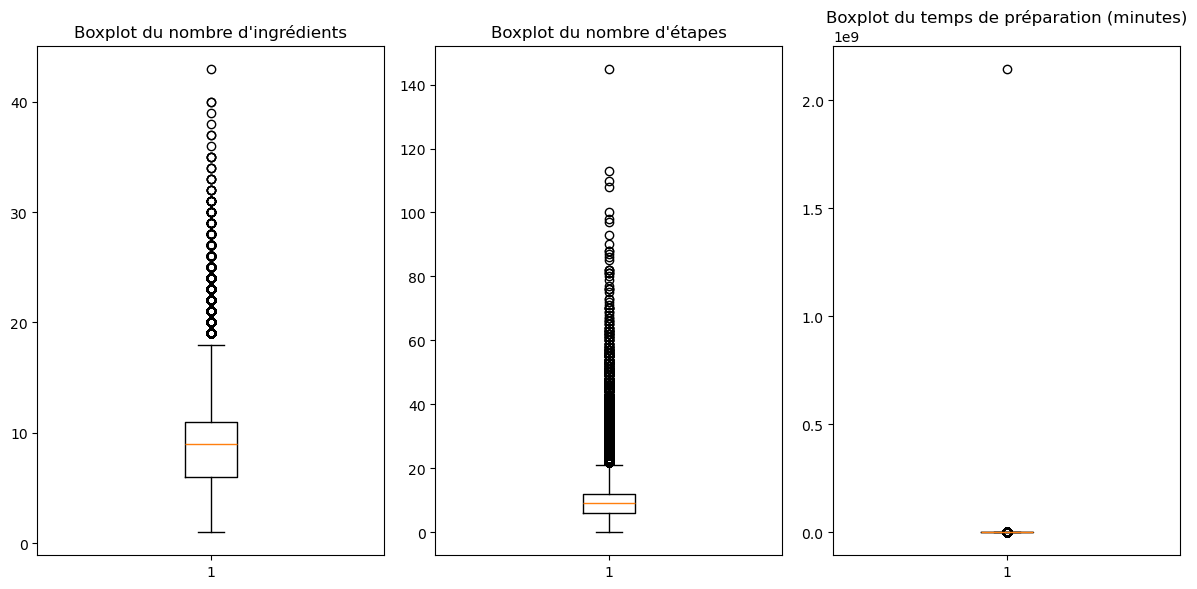

In [25]:
#visualisation des valeurs extrêmes, boxplot sur n_ingredients, n_steps, minutes
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.boxplot(data_recipes["n_ingredients"])
plt.title("Boxplot du nombre d'ingrédients")

plt.subplot(1, 3, 2)
plt.boxplot(data_recipes["n_steps"])
plt.title("Boxplot du nombre d'étapes")

plt.subplot(1, 3, 3)
plt.boxplot(data_recipes["minutes"])
plt.title("Boxplot du temps de préparation (minutes)")

plt.tight_layout()
plt.show()

Nous pouvons remarquer la présence de valeurs extrêmes dans les 3 colonnes, en particulier dans la colonne temps de préparation

In [26]:
#vérifier % de recettes avec un temps de préparation > 1 mois (43200 minutes)
long_recipes = data_recipes[data_recipes['minutes'] > 43200]
long_recipes_percentage = (long_recipes.shape[0] / data_recipes.shape[0]) * 100
print(f"Pourcentage de recettes avec un temps de préparation supérieur à 1 mois : {long_recipes_percentage:.2f}%")


Pourcentage de recettes avec un temps de préparation supérieur à 1 mois : 0.03%


Les recettes de plus de 1 représentant seulement 0.03% de toute les recettes, nous allons directement procéder à leurs suppressions

In [27]:
# Suppression des recettes nécessitant plus de 1 mois de préparation
data_recipes_cleaned = data_recipes[data_recipes['minutes'] <= 43200].copy()
print("Nombre de recettes après suppression des recettes longues :", data_recipes_cleaned.shape[0])

Nombre de recettes après suppression des recettes longues : 231566


In [28]:
## Nutrition score processing

data_recipes_cleaned[['calories','total_fat','sugar','sodium','protein','saturated_fat','carbohydrates']] = data_recipes_cleaned.nutrition.str.split(",",expand=True)
data_recipes_cleaned['calories'] = data_recipes_cleaned['calories'].apply(lambda x: x.replace('[','')) 
data_recipes_cleaned['carbohydrates'] = data_recipes_cleaned['carbohydrates'].apply(lambda x: x.replace(']','')) 

data_recipes_cleaned.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [29]:
data_recipes_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231566 entries, 0 to 231636
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   name            231566 non-null  object        
 1   id              231566 non-null  int64         
 2   minutes         231566 non-null  int64         
 3   contributor_id  231566 non-null  int64         
 4   submitted       231566 non-null  datetime64[ns]
 5   tags            231566 non-null  object        
 6   nutrition       231566 non-null  object        
 7   n_steps         231566 non-null  int64         
 8   steps           231566 non-null  object        
 9   description     231566 non-null  object        
 10  ingredients     231566 non-null  object        
 11  n_ingredients   231566 non-null  int64         
 12  calories        231566 non-null  object        
 13  total_fat       231566 non-null  object        
 14  sugar           231566 non-null  object  

In [30]:
# conversion des colonnes nutrition de 'object' à 'float' 
nutrition_cols = ['calories','total_fat','sugar','sodium','protein','saturated_fat','carbohydrates']
data_recipes_cleaned[nutrition_cols] = data_recipes_cleaned[nutrition_cols].astype(float)
data_recipes_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231566 entries, 0 to 231636
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   name            231566 non-null  object        
 1   id              231566 non-null  int64         
 2   minutes         231566 non-null  int64         
 3   contributor_id  231566 non-null  int64         
 4   submitted       231566 non-null  datetime64[ns]
 5   tags            231566 non-null  object        
 6   nutrition       231566 non-null  object        
 7   n_steps         231566 non-null  int64         
 8   steps           231566 non-null  object        
 9   description     231566 non-null  object        
 10  ingredients     231566 non-null  object        
 11  n_ingredients   231566 non-null  int64         
 12  calories        231566 non-null  float64       
 13  total_fat       231566 non-null  float64       
 14  sugar           231566 non-null  float64 

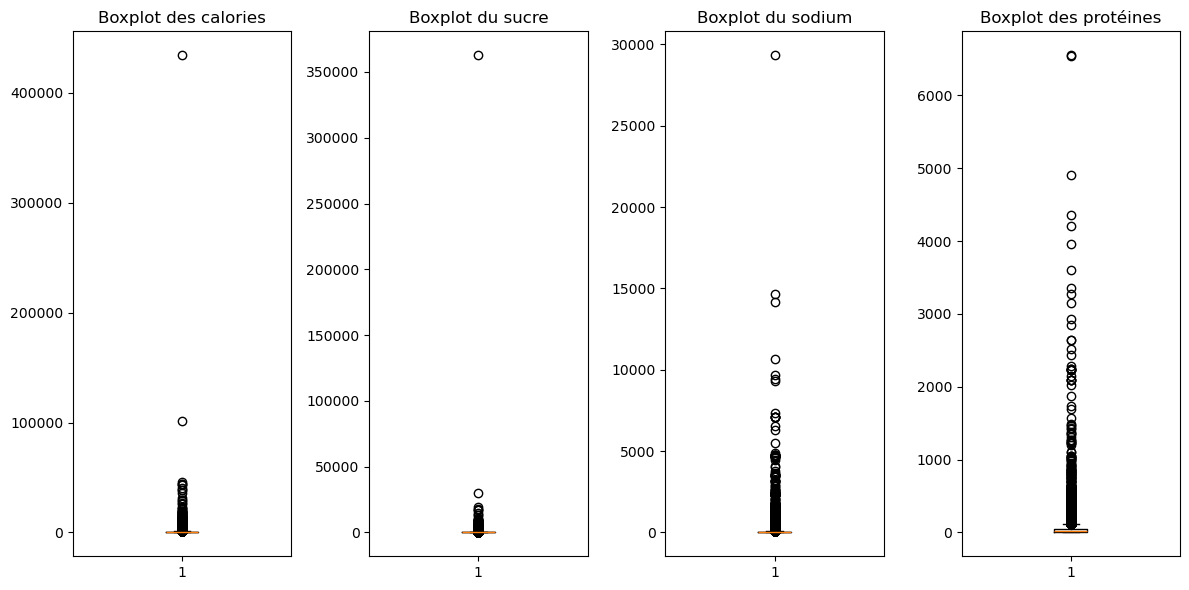

In [31]:
#boxplot de calories, sugar, sodium, protein
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.boxplot(data_recipes_cleaned["calories"])
plt.title("Boxplot des calories")
plt.subplot(1, 4, 2)
plt.boxplot(data_recipes_cleaned["sugar"])
plt.title("Boxplot du sucre")
plt.subplot(1, 4, 3)
plt.boxplot(data_recipes_cleaned["sodium"])
plt.title("Boxplot du sodium")
plt.subplot(1, 4, 4)
plt.boxplot(data_recipes_cleaned["protein"])
plt.title("Boxplot des protéines")
plt.tight_layout()
plt.show()

In [32]:
#% de recettes avec calories > 3000
high_calorie_recipes = data_recipes_cleaned[data_recipes_cleaned['calories'] > 3000]
high_calorie_percentage = (high_calorie_recipes.shape[0] / data_recipes_cleaned.shape[0]) * 100
print(f"Pourcentage de recettes avec plus de 3000 calories : {high_calorie_percentage:.2f}%")

Pourcentage de recettes avec plus de 3000 calories : 1.36%


Il est possible de remarquer des valeurs très extrêmes ! Les valeurs max sont des valeurs abérrantes cependant d'autre valeurs tel que les recettes à plus de 3 000 calories sont potentiellement des recettes avec des scores nutritionnels calculés pour la totalité de la recette et non normalisé (par exemple par portion). les valeurs nutritionnels pour une portion sont d'environs 200~800 kcal. Comme nous n'avons pas d'information sur la quantité considéré (portion ou recette total), on décide donc de supprimer les recettes à plus de 3000 calories sachant qu'ils représentent qu'un très petit pourcentage de recette. 

De même les valeurs nutrionnels pour : 
- les glucides : 20 ~ 100 g > suppression des recettes à plus de 500g
- protéines : 10 ~ 100 g > suppression des recettes à plus de 500g
- Sodium : 200 ~ 1500 mg > suppression des recettes à plus de 5000mg


In [33]:
# application de la fonction de suppression des valeurs abbérantes pour les variables nutritionnelles
#calories > 3000kcal
data_recipes_cleaned = remove_outliers_nutrition(data_recipes_cleaned, 'calories', 3000)

# sodium > 5000mg
data_recipes_cleaned = remove_outliers_nutrition(data_recipes_cleaned, 'sodium', 5000)
# protéines > 500g
data_recipes_cleaned = remove_outliers_nutrition(data_recipes_cleaned, 'protein', 500)

#sucres > 500g
data_recipes_cleaned = remove_outliers_nutrition(data_recipes_cleaned, 'sugar', 500)

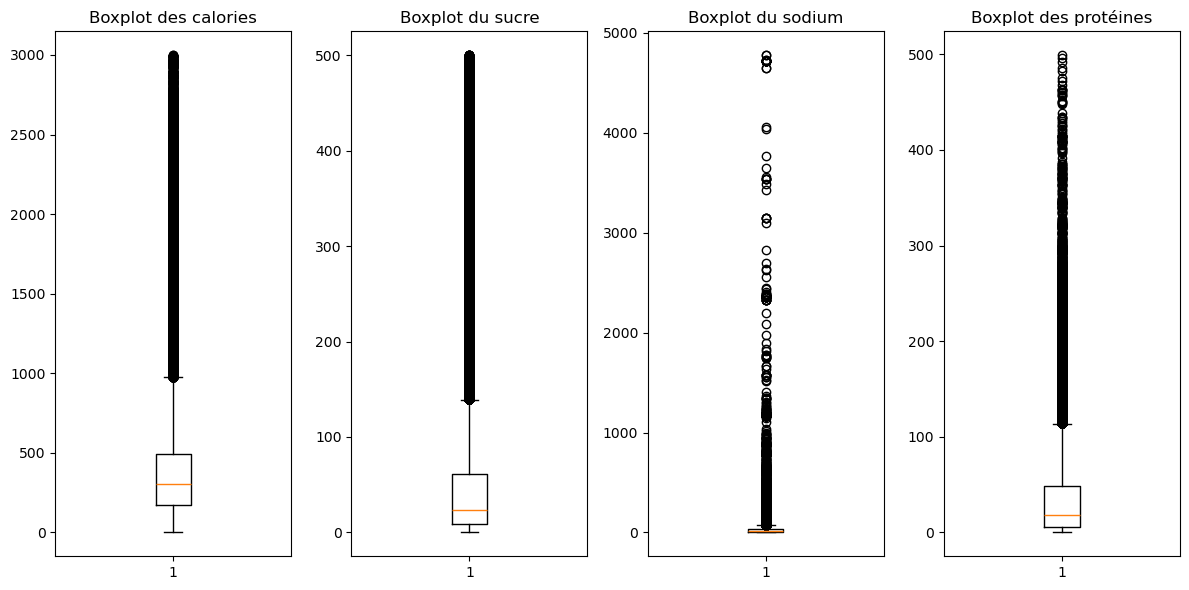

In [34]:
#boxplot de calories, sugar, sodium, protein
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.boxplot(data_recipes_cleaned["calories"])
plt.title("Boxplot des calories")
plt.subplot(1, 4, 2)
plt.boxplot(data_recipes_cleaned["sugar"])
plt.title("Boxplot du sucre")
plt.subplot(1, 4, 3)
plt.boxplot(data_recipes_cleaned["sodium"])
plt.title("Boxplot du sodium")
plt.subplot(1, 4, 4)
plt.boxplot(data_recipes_cleaned["protein"])
plt.title("Boxplot des protéines")
plt.tight_layout()
plt.show()

### EXTRACT DES DATASETS

In [37]:
#extraction du dataframe nettoyé final pour la table recipes
save_cleaned_datasets(data_recipes_cleaned, file_name="recipes_cleaned")

#extraction du dataframe nettoyé final pour la table interactions
save_cleaned_datasets(data_interactions, file_name="interactions_cleaned")

=== SAUVEGARDE DANS ..\data\processed ===
✅ Interactions: ..\data\processed\recipes_cleaned.csv ((224528, 19))
=== SAUVEGARDE DANS ..\data\processed ===
✅ Interactions: ..\data\processed\interactions_cleaned.csv ((1132367, 6))


{'interactions_file': WindowsPath('../data/processed/interactions_cleaned.csv')}

### merge les deux tables pour analyse

In [45]:
# rename la colonne 'id' en 'recipe_id' pour merge les deux tables
data_recipes_cleaned = data_recipes_cleaned.rename(columns={'id': 'recipe_id'})
merged_df = merge_datasets(recipe_sentiment, data_recipes_cleaned)

In [46]:
#suppression des lignes avec des valeurs manquantes après le merge
merged_df = merged_df.dropna()

In [40]:
merged_df.sample(5)

,recipe_id,total_reviews,negative_reviews,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,...,description,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
75125,129695,6,2,peach cobbler crusty and gooey carrie sheridan,50.0,221734.0,2005-07-13,"['60-minutes-or-less', 'time-to-make', 'course...","[711.4, 38.0, 398.0, 23.0, 10.0, 78.0, 41.0]",11.0,...,takes 10 minutes to make - everyone asks for t...,"['butter', 'peach halves in syrup', 'sugar', '...",8.0,711.4,38.0,398.0,23.0,10.0,78.0,41.0
226852,497799,1,0,traditional cole slaw,20.0,2739476.0,2013-03-18,"['30-minutes-or-less', 'time-to-make', 'course...","[141.0, 16.0, 16.0, 9.0, 2.0, 9.0, 3.0]",19.0,...,this is an adaptation of my grandmother's reci...,"['cabbage', 'salt & pepper', 'sugar', 'mayonna...",6.0,141.0,16.0,16.0,9.0,2.0,9.0,3.0
169004,322021,1,0,supersonic caesar salad dressing,15.0,628779.0,2008-08-28,"['15-minutes-or-less', 'time-to-make', 'course...","[195.4, 30.0, 4.0, 9.0, 3.0, 15.0, 1.0]",4.0,...,from everyday with rachael ray. i subbed ancho...,"['canned anchovy fillets', 'garlic clove', 'le...",9.0,195.4,30.0,4.0,9.0,3.0,15.0,1.0
63530,109202,1,0,ez chicken noodle soup,40.0,46431.0,2005-01-23,"['60-minutes-or-less', 'time-to-make', 'course...","[714.5, 71.0, 22.0, 58.0, 108.0, 57.0, 6.0]",5.0,...,"this recipe is quick, easy and always a hit in...","['chicken broth', 'thyme', 'garlic powder', 'f...",12.0,714.5,71.0,22.0,58.0,108.0,57.0,6.0
31046,54926,1,0,oatmeal cake with coconut pecan frosting,65.0,66321.0,2003-02-26,"['weeknight', 'time-to-make', 'course', 'main-...","[421.3, 30.0, 211.0, 7.0, 6.0, 33.0, 20.0]",10.0,...,tried and true..this is yummy !!,"['boiling water', 'oatmeal', 'margarine', 'sug...",13.0,421.3,30.0,211.0,7.0,6.0,33.0,20.0


In [47]:
#drop les colonnes inutiles
merged_df_cleaned = merged_df.drop(columns=['name','description','contributor_id'])
merged_df_cleaned.head()

,recipe_id,total_reviews,negative_reviews,minutes,submitted,tags,nutrition,n_steps,steps,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,38,4,0,1485.0,1999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...","[170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]",13.0,"['toss 2 cups berries with sugar', 'let stand ...","['blueberries', 'granulated sugar', 'vanilla y...",4.0,170.9,3.0,120.0,1.0,6.0,6.0,12.0
1,39,1,1,265.0,1999-08-29,"['weeknight', 'time-to-make', 'course', 'main-...","[1110.7, 90.0, 81.0, 15.0, 126.0, 82.0, 28.0]",17.0,['soak saffron in warm milk for 5 minutes and ...,"['saffron', 'milk', 'hot green chili peppers',...",26.0,1110.7,90.0,81.0,15.0,126.0,82.0,28.0
2,40,9,1,35.0,1999-09-05,"['60-minutes-or-less', 'time-to-make', 'course...","[311.1, 0.0, 308.0, 0.0, 0.0, 0.0, 27.0]",8.0,"['into a 1 quart jar with tight fitting lid , ...","['sugar', 'lemons, rind of', 'fresh water', 'f...",6.0,311.1,0.0,308.0,0.0,0.0,0.0,27.0
3,41,2,0,1460.0,1999-09-03,"['weeknight', 'time-to-make', 'course', 'main-...","[536.1, 36.0, 128.0, 64.0, 58.0, 19.0, 21.0]",18.0,"['drain the tofu , carefully squeezing out exc...","['extra firm tofu', 'eggplant', 'zucchini', 'r...",15.0,536.1,36.0,128.0,64.0,58.0,19.0,21.0
4,43,1,1,140.0,1999-08-21,"['weeknight', 'time-to-make', 'course', 'cuisi...","[437.9, 29.0, 170.0, 11.0, 13.0, 54.0, 19.0]",35.0,"['graham cracker crust: in small bowl , combin...","['graham cracker crumbs', 'sugar', 'butter', '...",15.0,437.9,29.0,170.0,11.0,13.0,54.0,19.0


In [48]:
#export du dataset fusionné nettoyé
save_cleaned_datasets(merged_df_cleaned, file_name="merged_cleaned")

=== SAUVEGARDE DANS ..\data\processed ===
✅ Interactions: ..\data\processed\merged_cleaned.csv ((224528, 18))


{'interactions_file': WindowsPath('../data/processed/merged_cleaned.csv')}